# The machine learning component of our project 
--> predicting yield from enviornmental factors

## imports

In [1]:
import pickle # we pickled the input
import os     # file operations

import pandas as pd # file reading
import numpy as np  # numerical operations

from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf   # Deep learning
import sklearn             # metrics and validation

import matplotlib.pyplot as plt

In [3]:
# change dir to project folder 
work_dir = '/content/drive/MyDrive/RemoteSensing/RS_FinalProj'
os.chdir(work_dir)

## Bringing in the data

In [4]:
BATCH_SIZE = 8
SEED = 31415

### Yield

In [5]:
# labels data:
labels = pd.read_csv('./yield.csv', index_col='Corn_Yields')
# reformat titles
labels.index = [label.replace('_', ' ') for label in labels.index]
labels = labels.sort_index()
labels.head(5)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Avg.
Adair,152.8,104.4,137.8,169.3,176.5,190.3,175.2,149.5,176.6,169.7,160.2
Adams,151.7,109.8,147.6,169.9,169.6,187.4,179.9,171.6,NaN,174.2,162.4
Allamakee,173.3,153.6,162.1,175.6,175.4,205.1,190.5,198.4,187.2,197.4,181.9
Appanoose,120.1,44.5,109.1,170.9,154.3,186.3,170.0,NaN,166.8,145.0,140.8
Audubon,176.6,114.8,157.1,185.5,189.8,206.1,211.2,180.0,216.0,171.7,180.9


### Getting a baseline

In [6]:
baseline_yield = np.nanmean(labels.to_numpy())

In [7]:
mae_baseline = np.nanmean(np.abs(labels.to_numpy()-baseline_yield))
mse_baseline = np.nanmean(np.abs(labels.to_numpy()-baseline_yield)**2)
print(f'Baseline MAE: {mae_baseline}')
print(f'Baseline MSE: {mse_baseline}')

Baseline MAE: 20.63679245283019
Baseline MSE: 734.2967240566038


### Sensor data

In [8]:
# get the paths to the data files
image_collections = os.listdir('./masked_pickles')
image_collections = [os.path.join('./pickles', filename) for filename in image_collections if filename[-2:] != 'py']

data_by_yr = defaultdict(list)
for ic in image_collections:
  file_names = os.listdir(ic)
  file_paths = [os.path.join(ic, filename) for filename in file_names]
  yrs = [file.split('/')[-1][:4] for file in file_paths]  
  for file, yr in zip(file_paths, yrs):
    data_by_yr[yr].append(pickle.load(open(file, 'rb')))

In [9]:
# concatenate all the bands from different products together
for yr, data in data_by_yr.items():
  data_by_yr[yr] = np.concatenate(data, axis=-1)

In [10]:
# concatenate eveything by yrs
y = []
x = []
counties = []
for yr, data in data_by_yr.items():
  y.append(labels[yr])
  x.append(data)
  counties.append([str(yr)+' '+county for county in labels.index])

x = np.concatenate(x)
y = np.concatenate(y)
counties = np.concatenate(counties)

In [11]:
# since some yield values are NaN, we remove those
good_elements = np.logical_not(np.isnan(y))
x = x[good_elements]
y = y[good_elements]
counties = counties[good_elements]

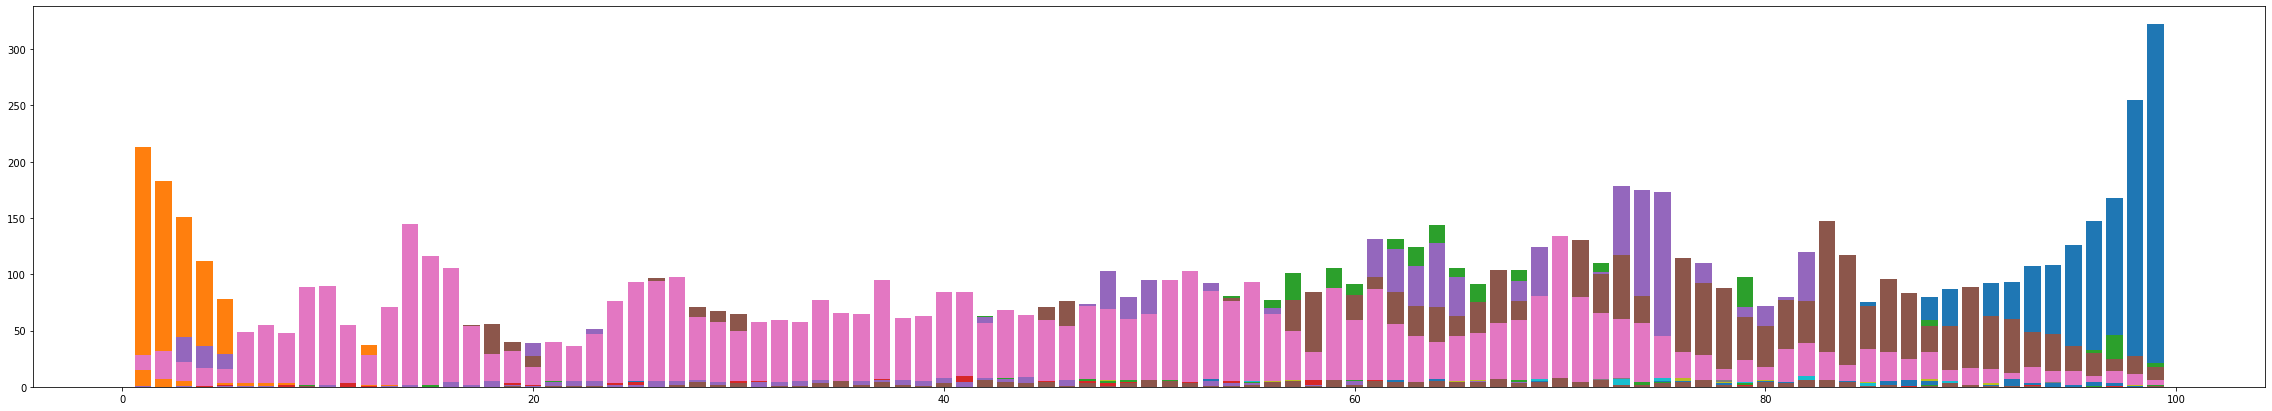

In [12]:
# visualize one sample
plt.figure(figsize=(40,7))
for ch in range(x.shape[-1]):
  plt.bar(np.arange(1, 100), x[0, 1:, ch])
plt.show()


In [13]:
def normalize(hists):
  # chop off the zero bin
  hists = hists[:, 1:, :]
  
  hists_shape = hists.shape
  for i in range(hists_shape[0]):
    # histogram-wise percent of max
    for j in range(hists_shape[-1]):
      hists[i, :, j] = hists[i, :, j]/hists[i, :, j].max()*100
    # standard normal
    #hists[i] = (hists[i]-hists[i].mean())/hists[i].std()

  return hists

In [14]:
x = normalize(x)

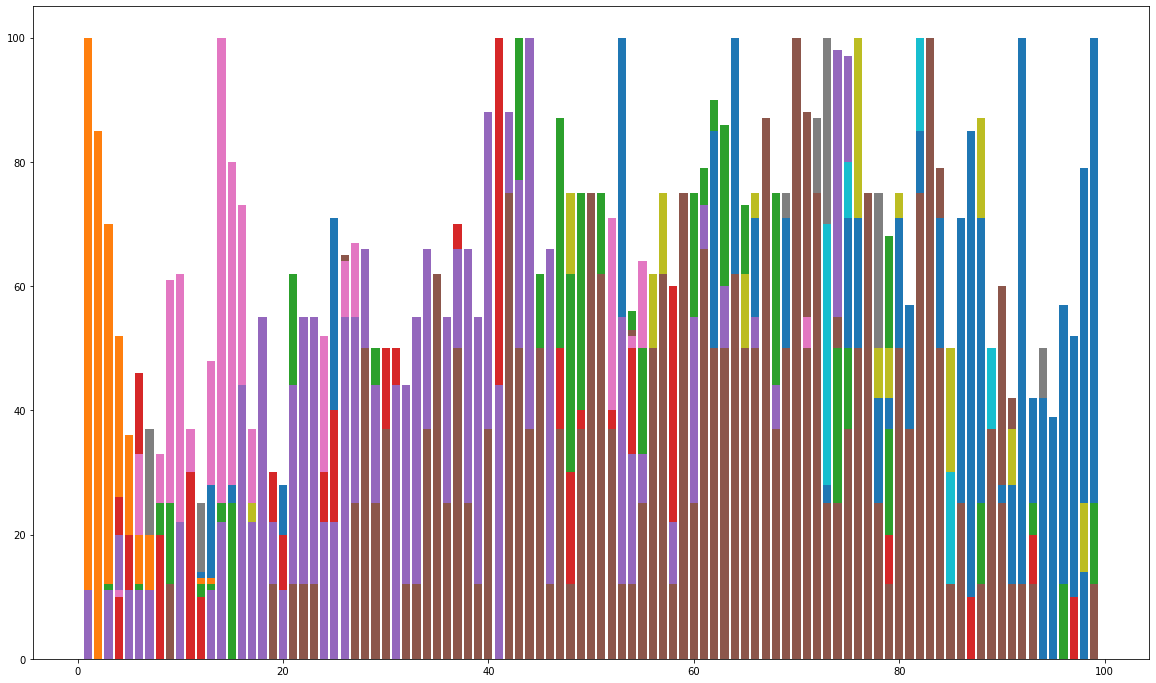

In [15]:
# visualize one sample
for i in range(1):
  plt.figure(figsize=(20,12))
  for ch in range(x.shape[-1]):
    plt.bar(np.arange(1, 100), x[i, :, ch])
  plt.show()


In [16]:
x_tr, x_val, y_tr, y_val, datapoint_tr, datapoint_val = train_test_split(x, y, counties, test_size=.2, random_state=SEED)

In [17]:
datapoint_val

array(['2015 Calhoun', '2015 O Brien', '2017 Davis', '2017 Cedar',
       '2013 Jackson', '2013 Jefferson', '2017 Hamilton', '2013 Page',
       '2016 Osceola', '2016 Adair', '2016 Davis', '2019 Plymouth',
       '2014 Mitchell', '2016 Allamakee', '2019 Franklin',
       '2014 Plymouth', '2015 Butler', '2016 Worth', '2019 Iowa',
       '2014 Allamakee', '2019 Poweshiek', '2018 Butler', '2013 Monona',
       '2019 Dallas', '2019 O Brien', '2019 Linn', '2016 Floyd',
       '2015 Mahaska', '2018 Carroll', '2018 Benton', '2016 Des Moines',
       '2015 Washington', '2014 Woodbury', '2017 Adams', '2014 Kossuth',
       '2015 Boone', '2013 Iowa', '2017 Marshall', '2013 Buchanan',
       '2017 Lyon', '2014 Montgomery', '2019 Appanoose', '2018 Kossuth',
       '2013 Keokuk', '2016 Henry', '2015 Floyd', '2015 Audubon',
       '2017 Fremont', '2013 Osceola', '2019 Jones', '2016 Linn',
       '2017 Sioux', '2018 Calhoun', '2013 Union', '2013 Scott',
       '2014 Lucas', '2015 Delaware', '2014 Cla

In [18]:
# into a dataset
ds_tr = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [19]:
# hacky way to get input size 
for item in ds_tr.as_numpy_iterator():
  input_shape = item[0].shape[:]
  break
print(f'Input shape: {input_shape}')

# print length of dataset
print(f'Length of training set: {len(ds_tr)}')
print(f'Length of validation set: {len(ds_val)}')

Input shape: (99, 16)
Length of training set: 534
Length of validation set: 134


In [20]:
ds_tr = ds_tr.batch(BATCH_SIZE)
ds_val = ds_val.batch(BATCH_SIZE)

# Machine Learning

In [21]:
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import (
        BatchNormalization,
        Conv1D,
        Dropout,
        SpatialDropout1D,
        Input,
        add,
        Activation,
        MaxPool1D, 
        Flatten, 
        Dense
    )       
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau               # modify lr

In [22]:
def hist_model(input_shape, 
               layer_num=3,
               stages=2,
               activation='relu', 
               filters=64,
               kernel=4,
               use_batch_norm=True,
               use_dropout=True, 
               dropout_rate=0.8,
               delta_dropout=0.0):
  """
  Arguments:
  Default Model Architecture for Yield Prediction:
  input_shape (tuple): input shape in the format (number_of_bins, number_of_bands): 
  layer_num (int): number of conv layers in a stage
  stages (int): number of stages
  activation (str, activation): activation type 
  filters (int): number of filters for the intial stage
  kernel (int): kernel size
  use_batch_norm (bool): whether or not to use batch norm
  use_dropout (bool): whether or not to use dropout
  dropout_rate (float): rate for dropout layers
  delta_dropout (float): change in dropout rate per convolutional layer

  Returns:
  model (keras.models.Model): the built model
  """
  inputs = Input(input_shape)
  x = inputs
  for s in range(stages):
    for _ in range(layer_num):
      x = Conv1D(filters*(s+1), kernel)(x)
      if use_dropout:
        x = Dropout(dropout_rate)(x)
      if delta_dropout != 0.0:
        dropout_rate += delta_dropout
      if use_batch_norm:
        x = BatchNormalization()(x)
      x = Activation(activation)(x)
    if (s+1 != stages):
      x = MaxPool1D()(x)
  x = Flatten()(x)
  x = Dense(1)(x)
  outputs = Activation('relu')(x)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

model = hist_model(input_shape)

model.compile(loss = MeanSquaredError(),
              optimizer = 'adam', 
              metrics = ['mae'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 16)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            4160      
_________________________________________________________________
dropout (Dropout)            (None, 96, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 96, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 93, 64)            16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 93, 64)            0     

In [23]:
filters = 64
kernel = 5
dropout_rate = 0.1

inputs = Input(input_shape)
x = inputs 
x = Conv1D(filters, kernel, activation='relu')(x)
x = SpatialDropout1D(dropout_rate)(x)
x = Flatten()(x)
x = Dense(filters, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(filters, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(filters*2, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(filters*4, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(filters*2, activation='relu')(x)
x = Dense(filters, activation='relu')(x)

x = Dense(1)(x)
outputs = Activation('relu')(x)
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(loss = MeanSquaredError(),
              optimizer = 'adam', 
              metrics = ['mae'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 99, 16)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 95, 64)            5184      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 95, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6080)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                389184    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320

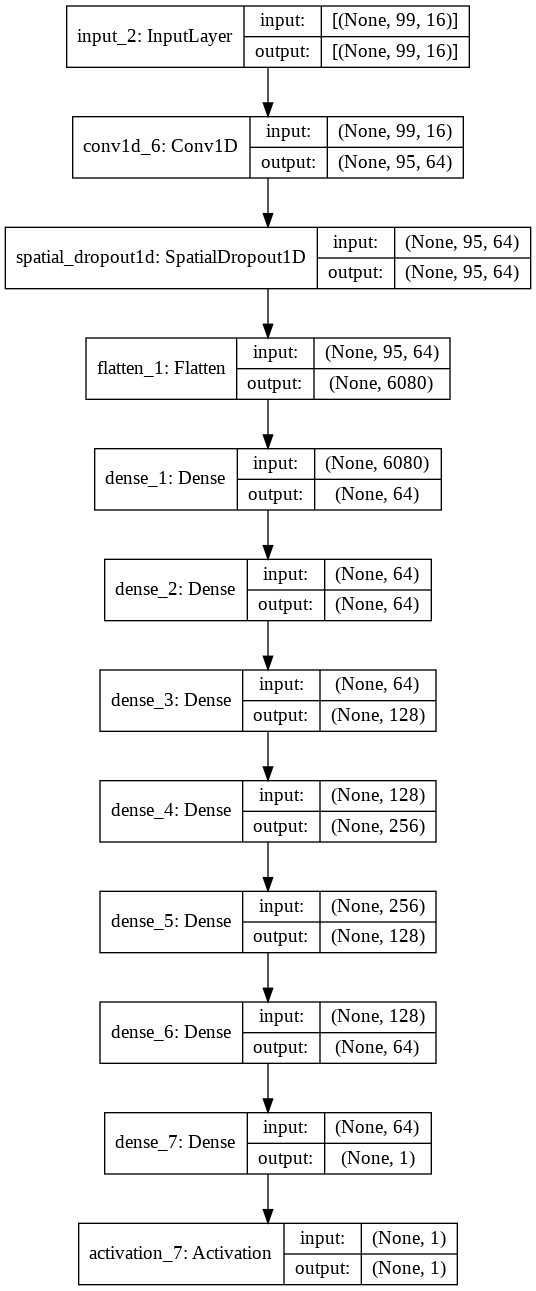

In [24]:
# visualize the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.8,
                               cooldown=0,
                               min_lr=0.5e-7,
                               patience = 20,
                               verbose=1)

In [27]:
history = model.fit(
    ds_tr,
    epochs = 200,
    validation_data = ds_val,
    callbacks = [lr_reducer]
)

Epoch 1/200
67/67 [==============================] - 0s 7ms/step - loss: 347.9237 - mae: 14.9707 - val_loss: 1556.9366 - val_mae: 37.1336
Epoch 2/200
67/67 [==============================] - 0s 7ms/step - loss: 620.6429 - mae: 20.1018 - val_loss: 617.1234 - val_mae: 21.8073
Epoch 3/200
67/67 [==============================] - 1s 8ms/step - loss: 432.0903 - mae: 17.0798 - val_loss: 208.7237 - val_mae: 10.8990
Epoch 4/200
67/67 [==============================] - 0s 7ms/step - loss: 475.6992 - mae: 17.5889 - val_loss: 199.4150 - val_mae: 10.7641
Epoch 5/200
67/67 [==============================] - 0s 7ms/step - loss: 240.7204 - mae: 12.4653 - val_loss: 283.7208 - val_mae: 13.9648
Epoch 6/200
67/67 [==============================] - 0s 7ms/step - loss: 414.4843 - mae: 16.6097 - val_loss: 210.1012 - val_mae: 11.5587
Epoch 7/200
67/67 [==============================] - 0s 7ms/step - loss: 332.7280 - mae: 14.6637 - val_loss: 190.5184 - val_mae: 10.5858
Epoch 8/200
67/67 [=====================

In [28]:
save_path ='./masked_trained_model_200e_conv_linear_spatialdrop.h5' 
model.save(save_path)

## Visualization of training

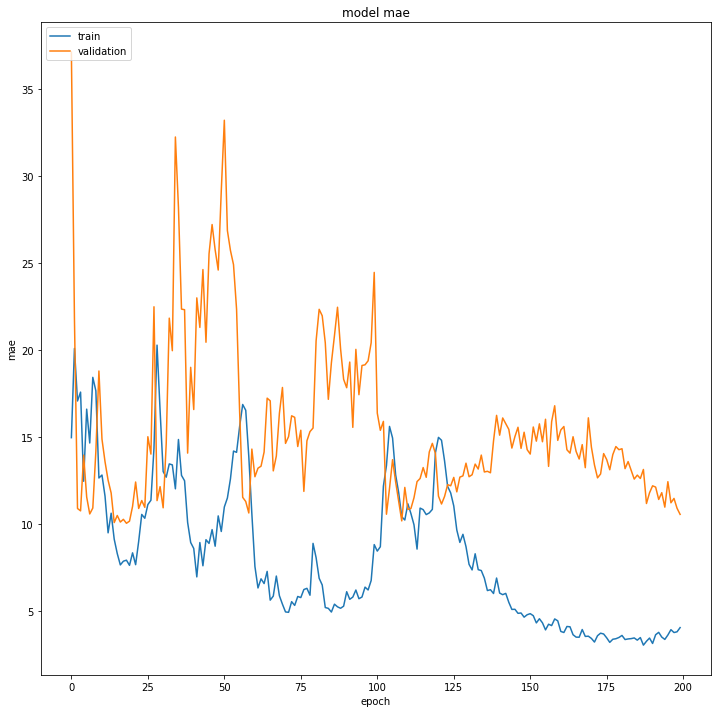

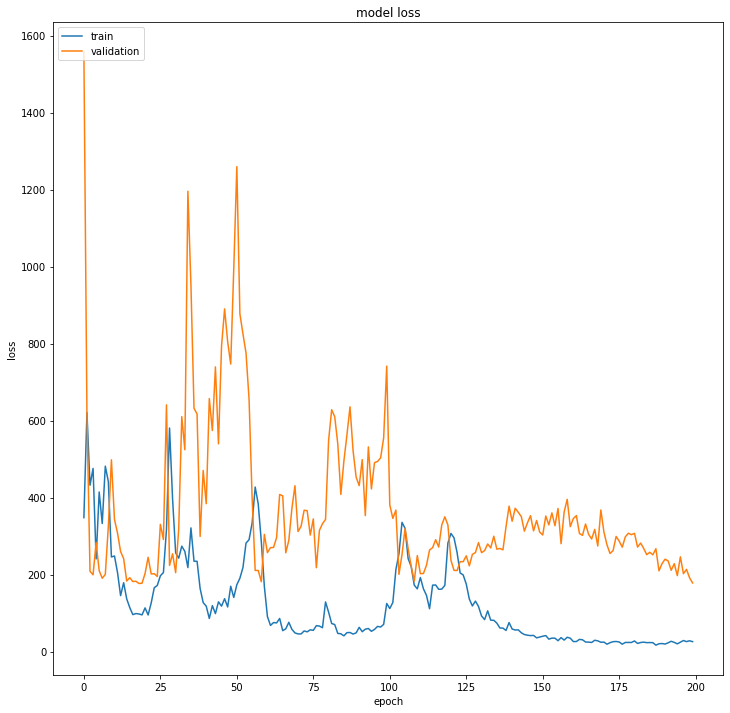

In [29]:
plt.figure(figsize=(12,12))
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure(figsize=(12,12))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
model.evaluate(ds_val)

17/17 [==============================] - 0s 3ms/step - loss: 178.3293 - mae: 10.5601


[178.32928466796875, 10.560091972351074]

# Pixel-wise predictions

In [31]:
import seaborn as sns

In [34]:
model = tf.keras.models.load_model('./masked_trained_model_200e_conv_linear_spatialdrop.h5' )

In [33]:
pixel_hists = list()
for file in os.listdir('./pixel-wise-calhoun'):
  pixel_hists.append(pickle.load(open('./pixel-wise-calhoun/'+ file, 'rb')))

In [35]:
calhoun_hists = np.concatenate(pixel_hists, axis=-1)
# reorder
calhoun_hists = np.transpose(calhoun_hists, axes=[1, 2, 0, -1])

In [36]:
yield_out = np.zeros(shape=calhoun_hists.shape[:2])
for i, x in enumerate(calhoun_hists):
  x = normalize(x)
  yield_out[i,:] =  np.squeeze(model(x))

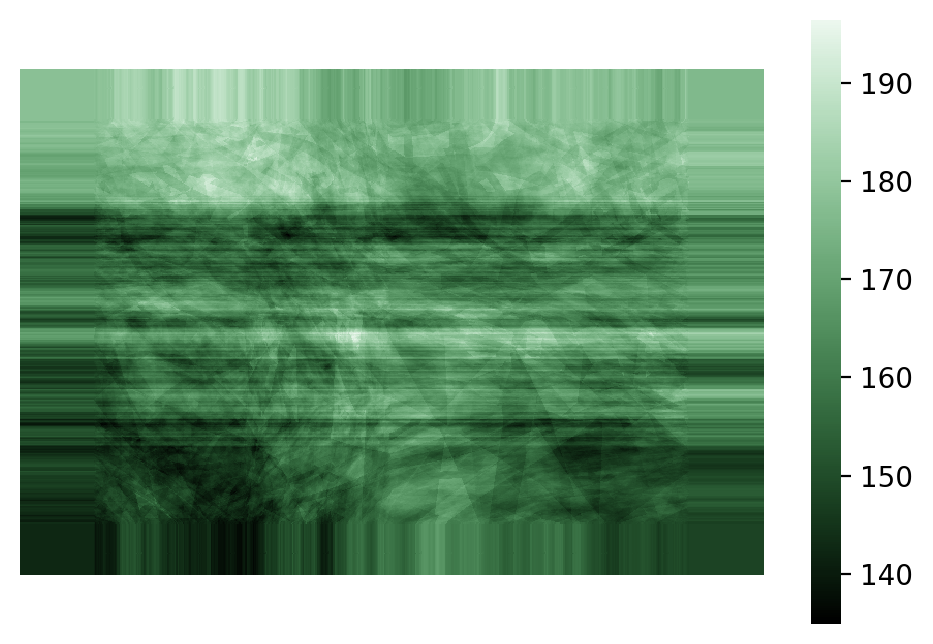

In [37]:
plt.figure(dpi=200)
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
ax = sns.heatmap(yield_out, cmap=cmap, square=True)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
#plt.savefig('./calhoun_yieldmap_m', dpi=400)
plt.show()